<a href="https://colab.research.google.com/github/obeabi/AirlineSentiment/blob/main/TQQQ_TLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade yfinance
!pip install  --upgrade pandas_ta
!pip install ta pandas_ta

In [22]:
import yfinance as yf
print(yf.__version__)
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time
import ta
import matplotlib.pyplot as plt
print("Libraries Installed!")

0.2.66
Libraries Installed!


In [4]:
# Download data
tickers = ["TQQQ", "TLT"]
data = yf.download(tickers, start="2024-01-01", interval="1d",auto_adjust=True)["Close"]

# Compute returns
returns = data.pct_change()

# Lookback window (3 months ~ 63 trading days)
window = 63

# Inspect dataframe
data.head()

[*********************100%***********************]  2 of 2 completed


Ticker,TLT,TQQQ
Date,,
2024-01-02,91.412582,47.146381
2024-01-03,91.793816,45.637856
2024-01-04,90.399063,44.873795
2024-01-05,89.534302,45.040321
2024-01-08,90.417648,47.753716


In [5]:

def compute_relative_strength(prices, method="raw"):
    roc = prices.pct_change(window) # 3-month return

    if method == "raw":
        rs = roc
    elif method == "vol_adj":
        vol = returns.rolling(window).std() * np.sqrt(window)
        rs = roc / vol
    else:
        raise ValueError("Method must be 'raw' or 'vol_adj'")

    return rs


    # Compute signals
rs_raw = compute_relative_strength(data, method="raw")
rs_vol = compute_relative_strength(data, method="vol_adj")



In [6]:
# Resample monthly (take last available signal each month)
rs_raw_m = rs_raw.resample("ME").last()

#print("Relative strengths are :",rs_raw_m )
rs_raw_m.tail(10)

Ticker,TLT,TQQQ
Date,,
2025-01-31,-0.036126,0.079538
2025-02-28,0.007695,-0.043774
2025-03-31,0.043524,-0.348793
2025-04-30,0.027105,-0.329901
2025-05-31,-0.056775,-0.062914
2025-06-30,-0.010162,0.451558
2025-07-31,-0.017646,0.611824
2025-08-31,0.015069,0.280145
2025-09-30,0.021701,0.279501


In [7]:
# Resample monthly (take last available signal each month)
rs_vol_m = rs_vol.resample("ME").last()
#print("Volatility normalized Relative strengths are :",rs_vol_m )
rs_vol_m.tail(10)

Ticker,TLT,TQQQ
Date,,
2025-01-31,-0.504466,0.275970
2025-02-28,0.117830,-0.152511
2025-03-31,0.690922,-1.059412
2025-04-30,0.342711,-0.583493
2025-05-31,-0.756811,-0.109824
2025-06-30,-0.131659,0.851610
2025-07-31,-0.291671,2.937019
2025-08-31,0.270168,1.553007
2025-09-30,0.404571,1.728529


In [8]:
def generate_signals(rs):
    # Create a Series filled with 'CASH' for rows that are all NaN
    signals = pd.Series("CASH", index=rs.index)

    # Identify rows that are not all NaN
    valid_rows = rs.notna().any(axis=1)

    # For valid rows, pick the strongest asset
    signals.loc[valid_rows] = rs[valid_rows].idxmax(axis=1)

    # Apply volatility filter: go to CASH if max < 0
    signals.loc[rs.max(axis=1) < 0] = "CASH"

    return signals

signals_raw = generate_signals(rs_raw_m)
signals_vol = generate_signals(rs_vol_m)

# Strategy returns
monthly_returns = returns.resample("ME").apply(lambda x: (1+x).prod() - 1)

monthly_returns


Ticker,TLT,TQQQ
Date,,
2024-01-31,-0.016784,0.093705
2024-02-29,-0.022522,0.146656
2024-03-31,0.007829,0.023561
2024-04-30,-0.064555,-0.143275
2024-05-31,0.028870,0.185628
2024-06-30,0.018171,0.185068
2024-07-31,0.036300,-0.075047
2024-08-31,0.021112,0.004833
2024-09-30,0.019994,0.059954


In [9]:
signals_vol.index[:-1]

signals_vol.loc['2025-09-30']

'TQQQ'

In [10]:
def backtest(signals, cap_tqqq=False):
    strat_rets = []
    for date in signals.index[:-1]:
        asset = signals.loc[date]
        next_ret = monthly_returns.loc[date]

        if asset == "CASH":
            strat_rets.append(0)
        elif asset == "TQQQ" and cap_tqqq:
            strat_rets.append(0.7 * next_ret["TQQQ"]) # 50% cap
        #elif asset == "TQQQ":
            # Instead of 50% TQQQ + 50% cash
            #strat_rets.append(0.5 * next_ret["TQQQ"] + 0.5 * next_ret["QQQ"])
        else:
            strat_rets.append(next_ret[asset])

    return pd.Series(strat_rets, index=signals.index[:-1])

# Backtests
bt_raw = backtest(signals_raw, cap_tqqq=True)
bt_vol = backtest(signals_vol, cap_tqqq=True)

# Equity curves
equity_raw = (1 + bt_raw).cumprod()
equity_vol = (1 + bt_vol).cumprod()

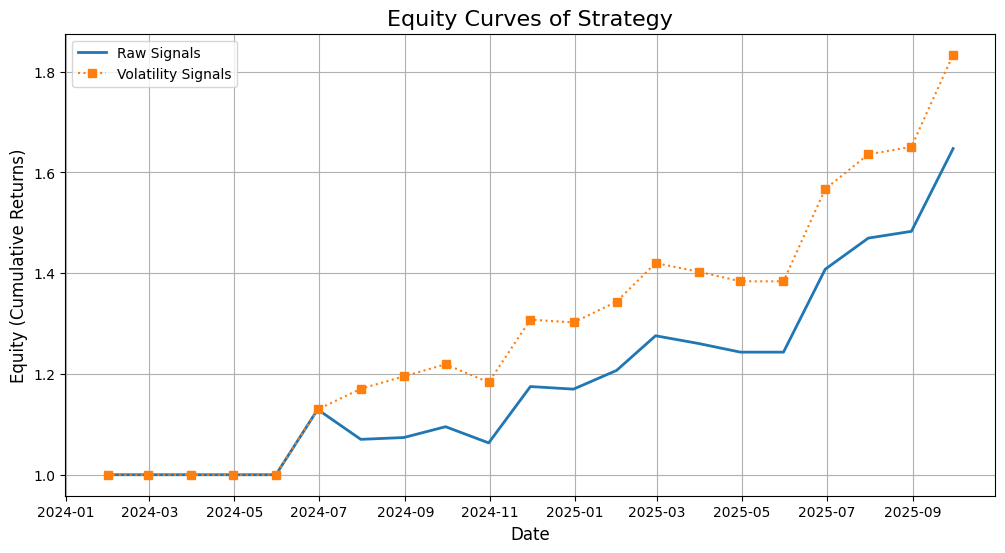

In [11]:

plt.figure(figsize=(12,6))

# Raw signals: solid line
plt.plot(equity_raw, label="Raw Signals", linewidth=2)

# Volatility signals: dotted line with square markers
plt.plot(
    equity_vol,
    label="Volatility Signals",
    linestyle=":",   # dotted line
    marker="s",     # square markers
    markersize=6,
    linewidth=1.5
)

plt.title("Equity Curves of Strategy", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Equity (Cumulative Returns)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



In [12]:


def evaluate_strategy(strategy_returns, periods_per_year=12, risk_free=0.0):
    """
    Evaluate a strategy's performance metrics.

    Parameters:
    - strategy_returns: pd.Series of returns (monthly or daily)
    - periods_per_year: 12 for monthly, 252 for daily
    - risk_free: annual risk-free rate (default 0)

    Returns:
    - pd.Series with key metrics
    """

    # Remove NaNs
    returns = strategy_returns.dropna()

    # Cumulative return
    cumulative = (1 + returns).prod() - 1

    # Annualized return
    ann_return = (1 + cumulative) ** (periods_per_year / len(returns)) - 1

    # Annualized volatility
    ann_vol = returns.std() * np.sqrt(periods_per_year)

    # Sharpe ratio
    sharpe = (ann_return - risk_free) / ann_vol if ann_vol != 0 else np.nan

    # Equity curve & drawdowns
    equity = (1 + returns).cumprod()
    drawdown = equity / equity.cummax() - 1
    max_dd = drawdown.min()

    # Calmar ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else np.nan

    # Sortino ratio
    downside_std = returns[returns < 0].std() * np.sqrt(periods_per_year)
    sortino = (ann_return - risk_free) / downside_std if downside_std != 0 else np.nan

    # Win rate / hit ratio
    win_rate = (returns > 0).mean()

    metrics = {
        "Cumulative Return": cumulative,
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Calmar Ratio": calmar,
        "Sortino Ratio": sortino,
        "Hit Ratio": win_rate
    }

    return pd.Series(metrics)

# Example usage
metrics_raw = evaluate_strategy(bt_raw)
metrics_vol = evaluate_strategy(bt_vol)

# Combine into one table
metrics_comparison = pd.DataFrame({
    "Raw RS": metrics_raw,
    "Volatility-Weighted RS": metrics_vol
})

metrics_comparison


,Raw RS,Volatility-Weighted RS
Cumulative Return,0.647356,0.833646
Annualized Return,0.330082,0.414054
Annualized Volatility,0.181409,0.169546
Sharpe Ratio,1.819549,2.442133
Max Drawdown,-0.058786,-0.029356
Calmar Ratio,5.615012,14.104667
Sortino Ratio,4.976368,11.396987
Hit Ratio,0.476190,0.523810


In [13]:
# Step 1: Fetch data
tickers = ["TQQQ", "TLT"]


monthly_prices = yf.download(tickers, start="2019-01-01", interval="1mo", auto_adjust=True)["Close"]

# Drop missing values
monthly_prices = monthly_prices.dropna()

# Step 2: Compute monthly returns
monthly_returns = monthly_prices.pct_change()

# Step 3: Compute relative strength
rs_1m = monthly_returns["TQQQ"] - monthly_returns["TLT"]
rs_3m = monthly_prices["TQQQ"].pct_change(3) - monthly_prices["TLT"].pct_change(3)

# Step 4: Put into DataFrame
signals = pd.DataFrame(index=monthly_prices.index)
signals["RS_1M"] = rs_1m
signals["RS_3M"] = rs_3m

signals

[*********************100%***********************]  2 of 2 completed


,RS_1M,RS_3M
Date,,
2019-01-01,NaN,NaN
2019-02-01,0.101714,NaN
2019-03-01,0.054238,NaN
2019-04-01,0.186845,0.388159
2019-05-01,-0.308631,-0.121355
...,...,...
2025-06-01,0.159118,0.473192
2025-07-01,0.077150,0.629603
2025-08-01,0.013002,0.265220


In [29]:
# Step 4: Determine regime (3M RS) and entry timing (1M RS)
def decide(row):
    if pd.isna(row["RS_1M"]) or pd.isna(row["RS_3M"]):
        return "No Signal"

    # Step 2: Regime (3M filter)
    if row["RS_3M"] > 0:
        regime = "Risk-On (favor TQQQ)"
    else:
        regime = "Risk-Off (favor TLT)"

    # Step 3: Entry timing (1M confirmation)
    if row["RS_3M"] > 0 and row["RS_1M"] > 0:
        decision = "ENTER TQQQ ✅"
    elif row["RS_3M"] < 0 and row["RS_1M"] < 0:
        decision = "ENTER TLT ✅"
    else:
        decision = "WAIT (no alignment)"

    return f"Regime: {regime}  | Decision: {decision}"

signals["Decision"]  = signals.apply(decide, axis=1)
#signals.loc[:,"Flag"] = signals["RS_3M"]>0

# Drop missing values
signals = signals.dropna()


# Print last 10 signals for inspection
signals.tail()[["RS_1M", "RS_3M", "Decision"]]

,RS_1M,RS_3M,Decision
Date,,,
2025-06-01,0.159118,0.473192,Regime: Risk-On (favor TQQQ) | Decision: ENTE...
2025-07-01,0.077150,0.629603,Regime: Risk-On (favor TQQQ) | Decision: ENTE...
2025-08-01,0.013002,0.265220,Regime: Risk-On (favor TQQQ) | Decision: ENTE...
2025-09-01,0.121186,0.225117,Regime: Risk-On (favor TQQQ) | Decision: ENTE...
2025-10-01,0.018156,0.158787,Regime: Risk-On (favor TQQQ) | Decision: ENTE...


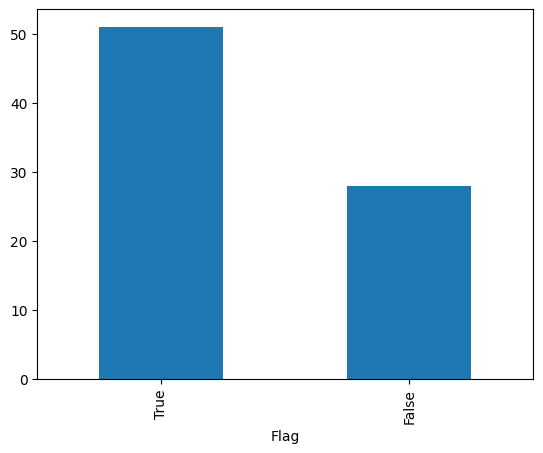

In [15]:
signals['Flag'].value_counts().plot(kind='bar')
plt.show()

[*********************100%***********************]  3 of 3 completed


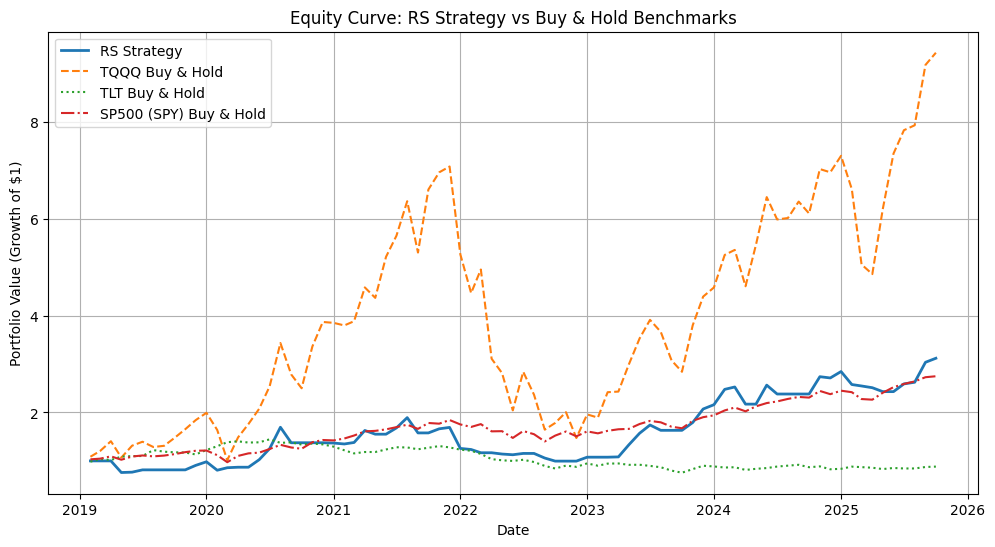

In [16]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get monthly data
tickers = ["TQQQ", "TLT", "SPY"]  # Add SPY
monthly_prices = yf.download(tickers, start="2019-01-01", interval="1mo", auto_adjust=True)["Close"]
monthly_prices = monthly_prices.dropna()

# Step 2: Compute monthly returns
monthly_returns = monthly_prices.pct_change()

# Step 3: Compute relative strength
rs_1m = monthly_returns["TQQQ"] - monthly_returns["TLT"]
rs_3m = monthly_prices["TQQQ"].pct_change(3) - monthly_prices["TLT"].pct_change(3)

# Step 4: Put into DataFrame
signals = pd.DataFrame(index=monthly_prices.index)
signals["RS_1M"] = rs_1m
signals["RS_3M"] = rs_3m

def decide(row):
    if pd.isna(row["RS_1M"]) or pd.isna(row["RS_3M"]):
        return "CASH"
    if row["RS_3M"] > 0 and row["RS_1M"] > 0:
        return "TQQQ"
    elif row["RS_3M"] < 0 and row["RS_1M"] < 0:
        return "TLT"
    else:
        return "CASH"

signals["Position"] = signals.apply(decide, axis=1)

# Step 5: Backtest
strategy_returns = []
for i in range(1, len(signals)):
    pos = signals["Position"].iloc[i-1]  # Position at previous month
    if pos == "TQQQ":
        strategy_returns.append(monthly_returns["TQQQ"].iloc[i])
    elif pos == "TLT":
        strategy_returns.append(monthly_returns["TLT"].iloc[i])
    else:  # CASH
        strategy_returns.append(0)

strategy_returns = pd.Series(strategy_returns, index=signals.index[1:], name="Strategy")

# Step 6: Equity curves
equity_curve = (1 + strategy_returns).cumprod()

bh_tqqq = (1 + monthly_returns["TQQQ"].dropna()).cumprod()
bh_tlt = (1 + monthly_returns["TLT"].dropna()).cumprod()
bh_spy = (1 + monthly_returns["SPY"].dropna()).cumprod()  # SP500 benchmark

# Step 7: Plot
plt.figure(figsize=(12,6))
plt.plot(equity_curve, label="RS Strategy", linewidth=2)
plt.plot(bh_tqqq, label="TQQQ Buy & Hold", linestyle="--")
plt.plot(bh_tlt, label="TLT Buy & Hold", linestyle=":")
plt.plot(bh_spy, label="SP500 (SPY) Buy & Hold", linestyle="-.")

plt.title("Equity Curve: RS Strategy vs Buy & Hold Benchmarks")
plt.ylabel("Portfolio Value (Growth of $1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  4 of 4 completed


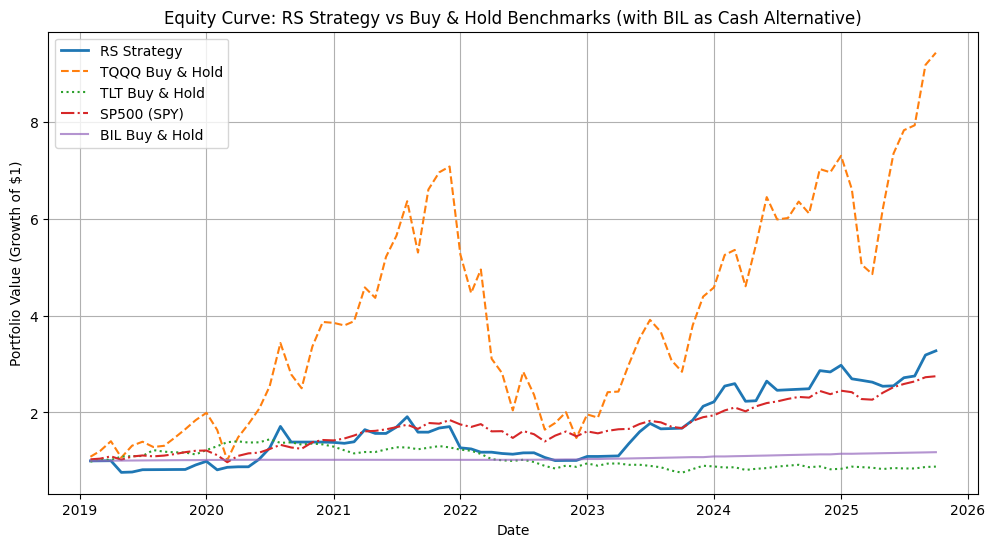

In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get monthly data
tickers = ["TQQQ", "TLT", "SPY", "BIL"]  # Added BIL
monthly_prices = yf.download(tickers, start="2019-01-01", interval="1mo", auto_adjust=True)["Close"]
monthly_prices = monthly_prices.dropna()

# Step 2: Compute monthly returns
monthly_returns = monthly_prices.pct_change()

# Step 3: Compute relative strength (TQQQ vs TLT)
rs_1m = monthly_returns["TQQQ"] - monthly_returns["TLT"]
rs_3m = monthly_prices["TQQQ"].pct_change(3) - monthly_prices["TLT"].pct_change(3)

# Step 4: Generate signals
signals = pd.DataFrame(index=monthly_prices.index)
signals["RS_1M"] = rs_1m
signals["RS_3M"] = rs_3m

def decide(row):
    if pd.isna(row["RS_1M"]) or pd.isna(row["RS_3M"]):
        return "BIL"   # fallback to BIL instead of cash
    if row["RS_3M"] > 0 and row["RS_1M"] > 0:
        return "TQQQ"
    elif row["RS_3M"] < 0 and row["RS_1M"] < 0:
        return "TLT"
    else:
        return "BIL"  # safe asset during "no alignment"

signals["Position"] = signals.apply(decide, axis=1)

# Step 5: Backtest
strategy_returns = []
for i in range(1, len(signals)):
    pos = signals["Position"].iloc[i-1]  # position from previous month
    strategy_returns.append(monthly_returns[pos].iloc[i])

strategy_returns = pd.Series(strategy_returns, index=signals.index[1:], name="Strategy")

# Step 6: Equity curves
equity_curve = (1 + strategy_returns).cumprod()

bh_tqqq = (1 + monthly_returns["TQQQ"].dropna()).cumprod()
bh_tlt = (1 + monthly_returns["TLT"].dropna()).cumprod()
bh_spy = (1 + monthly_returns["SPY"].dropna()).cumprod()
bh_bil = (1 + monthly_returns["BIL"].dropna()).cumprod()

# Step 7: Plot
plt.figure(figsize=(12,6))
plt.plot(equity_curve, label="RS Strategy", linewidth=2)
plt.plot(bh_tqqq, label="TQQQ Buy & Hold", linestyle="--")
plt.plot(bh_tlt, label="TLT Buy & Hold", linestyle=":")
plt.plot(bh_spy, label="SP500 (SPY)", linestyle="-.")
plt.plot(bh_bil, label="BIL Buy & Hold", linestyle="-", alpha=0.7)

plt.title("Equity Curve: RS Strategy vs Buy & Hold Benchmarks (with BIL as Cash Alternative)")
plt.ylabel("Portfolio Value (Growth of $1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  6 of 6 completed


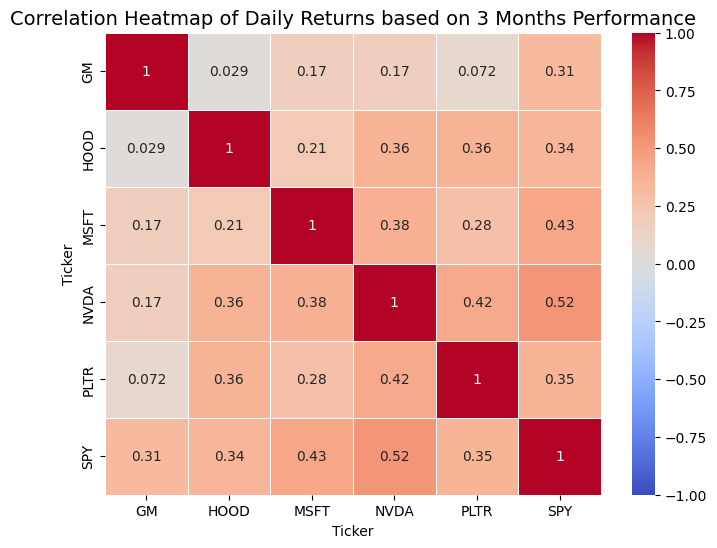

Ticker,GM,HOOD,MSFT,NVDA,PLTR,SPY
Ticker,,,,,,
GM,1.000000,0.029020,0.167134,0.166028,0.071649,0.313331
HOOD,0.029020,1.000000,0.206114,0.364871,0.364670,0.344997
MSFT,0.167134,0.206114,1.000000,0.377954,0.279115,0.434638
NVDA,0.166028,0.364871,0.377954,1.000000,0.420423,0.520076
PLTR,0.071649,0.364670,0.279115,0.420423,1.000000,0.354195
SPY,0.313331,0.344997,0.434638,0.520076,0.354195,1.000000


In [24]:

def get_correlation(tickers, period="3mo", interval="1d"):
    """
    Finds correlations.

    Parameters:
    -----------
    tickers : list
        All candidate tickers.
    period : str
        Data period for yfinance (default "3mo").
    interval : str
        Data interval (default "1d").

    Returns:
    --------
    corr_matrix : DataFrame
        Correlation matrix of daily returns.
    """
    # Step 1: Get prices
    data = yf.download(tickers, period=period, interval=interval,auto_adjust=True)["Close"]
    data = data.ffill()

    # Step 2: Convert to daily returns
    returns = data.pct_change().dropna()

    # Step 3: Correlation matrix
    corr_matrix = returns.corr()


     # Step 4: Plot heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        center=0,
        vmin=-1, vmax=1,
        linewidths=0.5
    )
    plt.title("Correlation Heatmap of Daily Returns based on 3 Months Performance", fontsize=14)
    plt.show()

    return corr_matrix


# Example usage
tickers = ['PLTR', 'NVDA', 'MSFT', 'HOOD', 'GM', 'SPY']  # Replace with your list of tickers
ranked_picks = tickers

corr_matrix = get_correlation(tickers)


corr_matrix